In [2]:
from numpy import *
from numpy.random import normal
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

### Rabi oscillations - two levels

In [3]:
## simple Rabi oscillation in two level atom

psi0 = array([1,0], complex) # population starts in |0>

delta = 10
omega = 2*pi # the rabi frequency

# atom+field Hamiltonian, hbar=1
Haf = array([[0,-omega/2],[-omega/2,0]])

numsteps = 100
tmin = 0
tmax = 3 
tpts = linspace(tmin,tmax,numsteps)

dpsi = lambda t,state: -1j*dot(Haf,state)

soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)

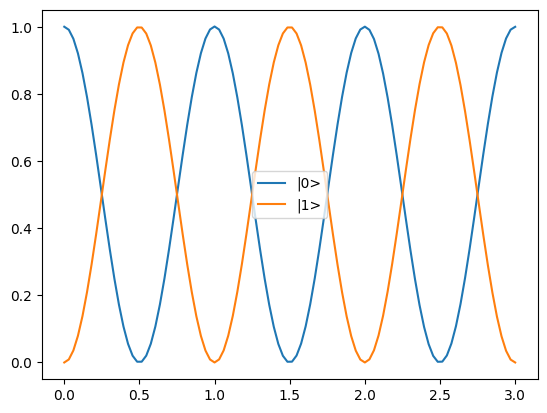

In [4]:
labels = ['|0>','|1>']
for i,y in enumerate(soln.y):
    plt.plot(soln.t,real(conjugate(y)*y),label=labels[i])
plt.legend(loc='best')

## Ramsey interference - two levels

### constant $\Delta$
no decoherence!

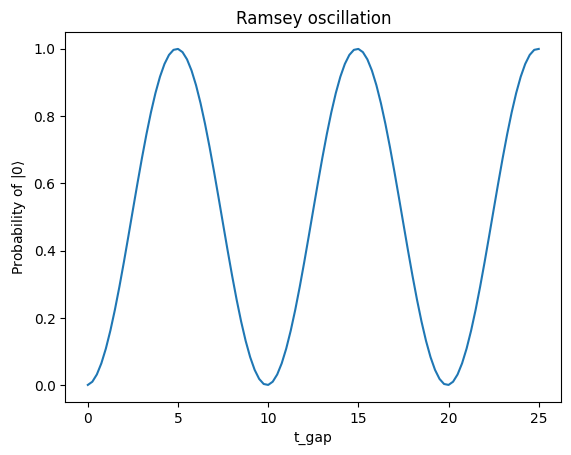

In [267]:
## simple Rabi oscillation in two level atom

psi0 = array([1,0], complex) # population starts in |0>

d = 2*pi/10 # delta. the energy shift between the states
o = 2*pi # the rabi frequency

# atom+field Hamiltonian, hbar=1
Haf = lambda t: array([[0,-o*exp(1j*d*t)/2],[-o*exp(-1j*d*t)/2,0]])

numsteps = 25
tmin = 0
tmax = pi/(2*o)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

# apply the first pi/2 pulse
soln = solve_ivp(dpsi,[tmin,tmax],psi0,vectorized=True)
psi0 = array([1,0], complex) 
soln = solve_ivp(dpsi,[0,pi/(2*o)],psi0,vectorized=True)
psi0 = array([soln.y[0,-1], soln.y[1,-1]],complex) # population in superposition of ms=0 and ms=1

# the state after evolving a time t along the equator
psi = lambda t: array([psi0[0], psi0[1]*exp(1j*d*t)])

numsteps = 25
tmin = 0
tmax =  pi/(2*o) # pi/2 time

tgaps = linspace(0,5*pi/abs(d),101)
p0 = zeros(len(tgaps))
p1 = zeros(len(tgaps))
for i,tgap in enumerate(tgaps): # let the state evolve on the equator for differnt gap times
    
    psi_equator = psi(tgap)
    
    # apply the second pi/2 pulse to the state after it has evolved on the equator for tgap
    soln = solve_ivp(dpsi,[tmin,tmax],psi_equator,vectorized=True)
    p0[i] = abs(soln.y[0,-1])**2
    p1[i] = abs(soln.y[1,-1])**2
plt.plot(tgaps,p0)
plt.title("Ramsey oscillation")
plt.xlabel("t_gap")
plt.ylabel(r"Probability of $|0\rangle$")
plt.show()

### Random $\Delta$
Sample $\Delta$ from a normal distribution

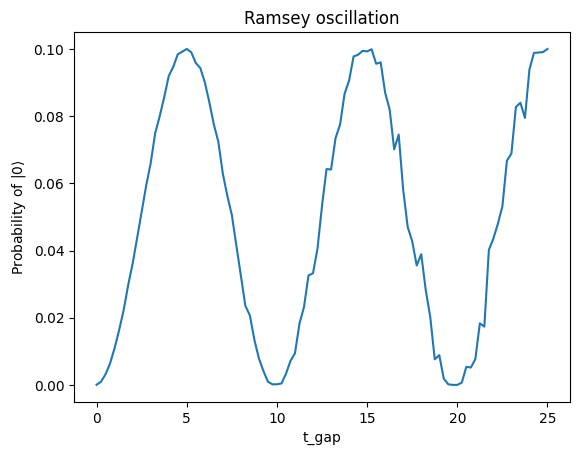

In [272]:
## simple Rabi oscillation in two level atom

psi0 = array([1,0], complex) # population starts in |0>

d_mean = 2*pi/10
d_std = 2*pi/1000

d = lambda t: normal(loc=d_mean, scale=d_std) # delta. for each time t, delta will be picked from a normal dist.
o = 2*pi # the rabi frequency

# atom+field Hamiltonian, hbar=1
Haf = lambda t: array([[0,-o*exp(1j*d_mean*t)/2],[-o*exp(-1j*d_mean*t)/2,0]])

tmin = 0
tmax = pi/(2*o)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

# apply the first pi/2 pulse
soln = solve_ivp(dpsi,[tmin,tmax],psi0,vectorized=True)
psi0 = array([1,0], complex) 
soln = solve_ivp(dpsi,[0,pi/(2*o)],psi0,vectorized=True)
psi0 = array([soln.y[0,-1], soln.y[1,-1]],complex) # population in superposition of ms=0 and ms=1

# average over many runs, where each run will have a different delta during the gap time

runs = 10
for j in range(runs):

    avg = zeros(len(tgaps))
    
    # the state after evolving a time t along the equator
    psi = lambda t: array([psi0[0], psi0[1]*exp(1j*d(t)*t)])

    tgaps = linspace(0,5*pi/abs(d_mean),101)
    p0 = zeros(len(tgaps))
    for i,tgap in enumerate(tgaps): # let the state evolve on the equator for differnt gap times

        psi_equator = psi(tgap)

        # apply the second pi/2 pulse to the state after it has evolved on the equator for tgap
        soln = solve_ivp(dpsi,[tmin,tmax],psi_equator,vectorized=True)
        p0[i] = abs(soln.y[0,-1])**2
        
    avg += p0
avg /= runs 
plt.plot(tgaps, avg)
plt.title("Ramsey oscillation")
plt.xlabel("t_gap")
plt.ylabel(r"Probability of $|0\rangle$")
plt.show()

## Rabi experiment - four levels

In [204]:
## Rabi oscillation in four level NV center

# triplet manifold, ignoring the m=-1
#
#         ---- mf=+1, +200 MHz detuned by N spin
#       /
# ms=-1 ---- ms=+1, 0 MHz detuned by N spin.
#  |    \
#  |     ---- ms=+1, +200 MHz detuned by N spin
#  |
#  | ~ 2.85 GHz
#  |
#  |
# ms=0 ----

psi0 = array([1,0,0,0], complex) # population starts in |g>

d1 = -2*pi*2.2 # MHz
d2 = 0
d3 = -d1
o1 = o2 = o3 = 2*pi*0.1 # assume that all transitions between ms=0 and ms=1 are driven equally (unpolarized light?)

# atom+field Hamiltonian, hbar=1
Haf = lambda t : 0.5*array([[0,-o1*exp(1j*d1*t),-o2*exp(1j*d2*t),-o3*exp(1j*d3*t)],
                            [-o1*exp(-1j*d1*t),0,0,0],
                            [-o2*exp(-1j*d2*t),0,0,0],
                            [-o3*exp(-1j*d3*t),0,0,0]])

numsteps = 100
tmin = 0
tmax = pi/(2*o1)
tpts = linspace(tmin,tmax,numsteps)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)

In [205]:
soln.y[0,-1],soln.y[1,-1],soln.y[2,-1],soln.y[3,-1]

((0.7058628787703664-2.228222877406643e-19j),
 (-0.03879199388119126+0.0007549820533264973j),
 (1.5308500718815566e-19+0.7065431406985213j),
 (0.03879199388119126+0.0007549820533264973j))

In [206]:
sum([abs(soln.y[i,-1])**2 for i in range(4)])

1.0004563908684778

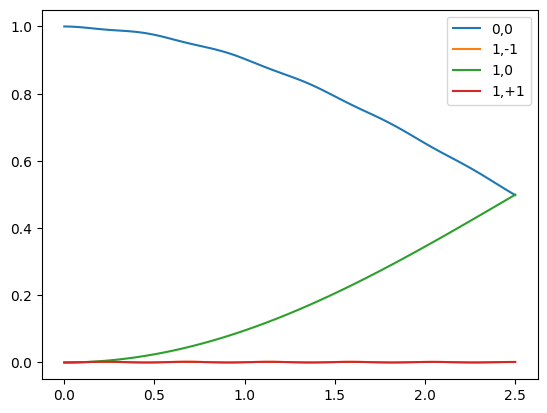

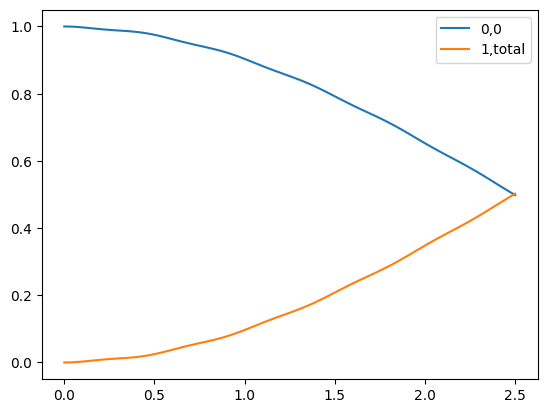

In [185]:
labels = ['0,0','1,-1','1,0','1,+1']
for i,y in enumerate(soln.y):
    plt.plot(soln.t,real(conjugate(y)*y),label=labels[i])
plt.legend(loc='best')
plt.show()
plt.plot(soln.t,real(conjugate(soln.y[0])*soln.y[0]),label=labels[0])
plt.plot(soln.t,real(conjugate(soln.y[1])*soln.y[1]+
                     conjugate(soln.y[2])*soln.y[2]+
                     conjugate(soln.y[3])*soln.y[3]),label='1,total')
plt.legend(loc='best')
plt.show()

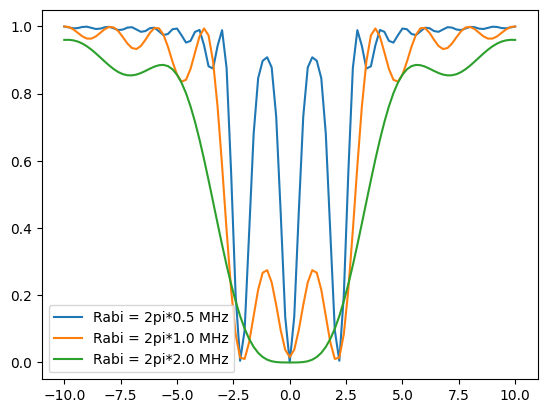

In [127]:
# resonance experiment.
# if we turn down the strength of the driving field we should be able to resolve the hyperfine structure

detunings = 2*pi*linspace(-10,10,101) # 2*pi*MHz

# power broadening is ~ 1.6*rabi, so want rabi_max/2pi > 4 MHz/1.6 to obscure the hyperfine structure
rabis = 2*pi*array([0.5,1,2]) # 2*pi*MHz.  

p0 = zeros(len(detunings))

fig,ax = plt.subplots()

for j,o1 in enumerate(rabis):
    for i,d in enumerate(detunings):
        
        tmax = (pi/o1)
        tpts = linspace(tmin,tmax,numsteps)
        
        o2 = o3 = o1 # assume that all transitions between ms=0 and ms=1 are driven equally

        # atom+field Hamiltonian, hbar=1
#         Haf = lambda t : 0.5*array([[0,-o1*exp(1j*(d1-d)*t),-o2*exp(1j*(d2-d)*t),-o3*exp(1j*(d3-d)*t)],
#                             [-o1*exp(-1j*(d1-d)*t),2*(d1-d),0,0],
#                             [-o2*exp(-1j*(d2-d)*t),0,2*(d2-d),0],
#                             [-o3*exp(-1j*(d3-d)*t),0,0,2*(d3-d)]])
        Haf = lambda t : 0.5*array([[0,-o1*exp(1j*(d1-d)*t),-o2*exp(1j*(d2-d)*t),-o3*exp(1j*(d3-d)*t)],
                            [-o1*exp(-1j*(d1-d)*t),0,0,0],
                            [-o2*exp(-1j*(d2-d)*t),0,0,0],
                            [-o3*exp(-1j*(d3-d)*t),0,0,0]])

        dpsi = lambda t,state: -1j*dot(Haf(t),state)

        soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)
        p0[i] = abs(soln.y[0,-1])**2

    ax.plot(detunings/(2*pi),p0,label=f'Rabi = 2pi*{o1/(2*pi)} MHz')
plt.legend()
plt.show()

## Ramsey experiment - four levels
this is more subtle than I had initially expected, and my model of three transitions with equal transition rates is probably not correct (for reproducing the NV behavior observed in experiments).

(0.0, 1.0)

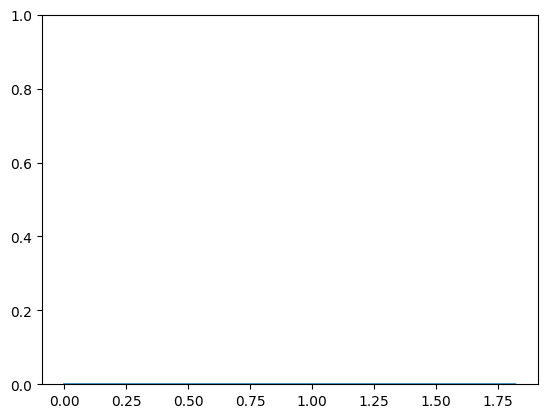

In [232]:
## Rabi oscillation in four level NV center

# triplet manifold, ignoring the m=-1
#
#         ---- mf=+1, +200 MHz detuned by N spin
#       /
# ms=-1 ---- ms=+1, 0 MHz detuned by N spin.
#  |    \
#  |     ---- ms=+1, +200 MHz detuned by N spin
#  |
#  | ~ 2.85 GHz
#  |
#  |
# ms=0 ----

psi0 = array([1,0,0,0], complex) # population starts in |g>

d1 = -2*pi*2.2 # MHz
d2 = 0
d3 = -d1
o1 = o2 = o3 = 2*pi*0.1 # assume that all transitions between ms=0 and ms=1 are driven equally (unpolarized light?)

# atom+field Hamiltonian, hbar=1
Haf = lambda t : 0.5*array([[0,-o1*exp(1j*d1*t),-o2*exp(1j*d2*t),-o3*exp(1j*d3*t)],
                            [-o1*exp(-1j*d1*t),0,0,0],
                            [-o2*exp(-1j*d2*t),0,0,0],
                            [-o3*exp(-1j*d3*t),0,0,0]])

numsteps = 100
tmin = 0
tmax = pi/(2*o1)
tpts = linspace(tmin,tmax,numsteps)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

# apply the second pi/2 pulse
soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)
psi0 = array([1,0,0,0], complex) 
soln = solve_ivp(dpsi,[0,pi/(2*o1)],psi0,vectorized=True)
psi0 = array([soln.y[i,-1] for i in range(4)],complex) # population in superposition of ms=0 and ms=1

# the state after evolving a time t along the equator
psi = lambda t: array([psi0[0], psi0[1]*exp(1j*d1*t), psi0[2]*exp(1j*d2*t), psi0[3]*exp(1j*d3*t)]) 

numsteps = 25
tmin = 0
tmax =  pi/(2*o1) # pi/2 time

tgaps = linspace(0,8*pi/abs(d1),51)
p0 = zeros(len(tgaps))
for i,tgap in enumerate(tgaps):
    
    # apply the second pi/2 pulse to the state after it has evolved on the equator for tgap
    soln = solve_ivp(dpsi,[tmin,tmax],psi(tgap),vectorized=True)
    p0[i] = abs(soln.y[0,-1])**2
plt.plot(tgaps,p0)
plt.ylim((0,1))

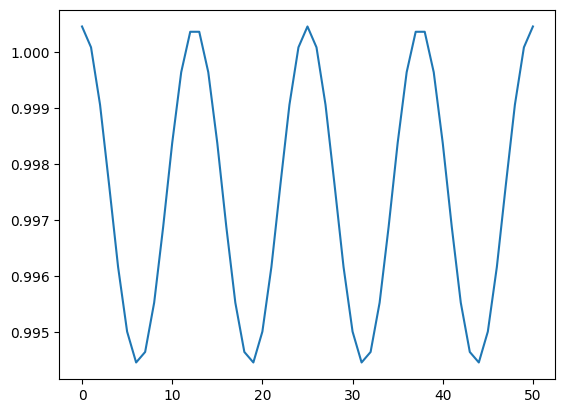

In [233]:
plt.plot([real(dot(conjugate(psi(t)),psi0)) for t in tgaps])

In [231]:
dot(conjugate(psi0*exp(-1j*pi)),psi0)

(-1.0006563969637172+1.2251070843130176e-16j)

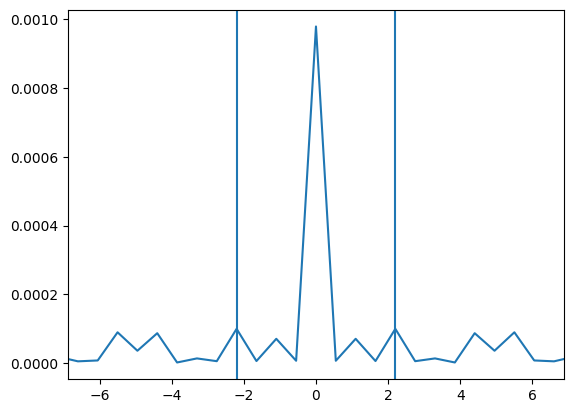

In [219]:
pts = len(tgaps)
yy = p0
YY = fftshift(fft(yy))
deltat = tgaps[1]-tgaps[0]
ff = linspace(-1/(2*deltat),1/(2*deltat),pts)
plt.plot(ff,abs(YY)/pts)
plt.xlim((-max(ff)/2,max(ff)/2))
plt.axvline((d1/(2*pi)))
plt.axvline((d3/(2*pi)))

## misc. tests

(-25.0, 25.0)

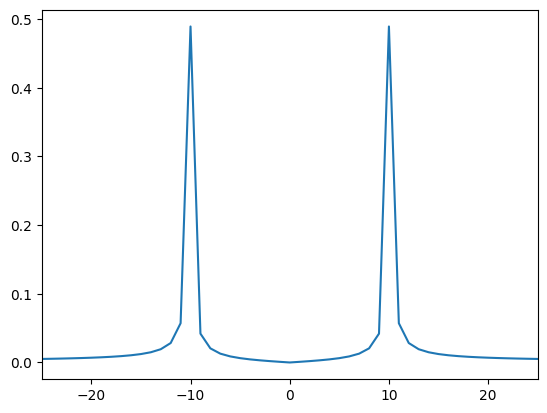

In [156]:
pts = 101
tt = linspace(0,1,pts) 
yy = sin(2*pi*10*tt)
YY = fftshift(fft(yy))
deltat = tt[1]-tt[0]
ff = linspace(-1/(2*deltat),1/(2*deltat),pts)
plt.plot(ff,abs(YY)/pts)
plt.xlim((-max(ff)/2,max(ff)/2))